In [1]:
import sys

from LIM_lightcone import paint_lightcone,make_survey
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
import time
import copy
from nbodykit.algorithms import FFTPower
%matplotlib inline

In [2]:
st = time.time()
test = make_survey(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                            lines=dict(CO=True),
                            models=dict(CO=dict(model_name='CO_Li16',model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_LCO':0.3})),
                           do_external_SFR = False, external_SFR = '',zmin = 2.4,zmax = 2.6,RA_min=-2.25*u.deg,RA_max=2.25*u.deg,RAObs_min=-2.25*u.deg,RAObs_max=2.25*u.deg,
                 output_root = "output/default",nuObs_max=34*u.GHz,nuObs_min=32*u.GHz,dnu=100*u.MHz,beam_FWHM=1.*u.deg))
print(time.time() - st)

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_173.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_179.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_170.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_172.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fits


/home/jlbernal/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


9.290730953216553


In [3]:
test.update(Tsys=0*u.K)

In [4]:
test.obs_map;

/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/dask/array/core.py:1444: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [5]:
import dask.array as da
from nbodykit.source.catalog import ArrayCatalog
from nbodykit.algorithms import FFTPower

In [6]:
def aniso_filter(k, v):
    '''
    Filter for k_perp and k_par modes separately. 
    Applies to an nbodykit mesh object as a regular filter.
    
    "True input":
        Rperp - 'angular' smoothing in the flat sky approximation
        Rpar - 'radial' smoothing from number of channels.
    
    
    
    
    Usage:
        mesh.apply(perp_filter, mode='complex', kind='wavenumber')

    
    NOTES:
    k[0] *= modifies the next iteration in the loop.
    Coordinates are fixed except for the k[1] which are 
    the coordinate that sets what slab is being altered?
    
    '''
    rper = sigma_perp
    rpar = sigma_par    
    newk = copy.deepcopy(k)
    
    
    #Smooth the k-modes anisotropically
    newk[0] *= rpar
    newk[1] *= rper
    newk[2] *= rper

    #Build smoothed values
    kk = sum(ki**2 for ki in newk)

    kk[kk==0]==1

    return np.exp(-0.5*kk)*v

In [7]:
#Convert the halo position in each volume to Cartesian coordinates (from Nbodykit)
ra,dec = da.broadcast_arrays(test.halos_in_survey['CO']['RA'], test.halos_in_survey['CO']['DEC'])
ra,dec  = da.deg2rad(ra),da.deg2rad(dec)
# cartesian coordinates
x = da.cos(dec) * da.cos(ra)
y = da.cos(dec) * da.sin(ra)
z = da.sin(dec)
pos = da.vstack([x,y,z]).T
ra,dec,redshift = da.broadcast_arrays(test.halos_in_survey['CO']['RA'], test.halos_in_survey['CO']['DEC'],
                                      test.halos_in_survey['CO']['Ztrue'])
#radial distances in Mpch/h
distances = test.cosmo.comoving_radial_distance(z)*u.Mpc
r = redshift.map_blocks(lambda z: (((test.cosmo.comoving_radial_distance(z)*u.Mpc).to(test.Mpch)).value), 
                        dtype=redshift.dtype)
cartesian_halopos = r[:,None] * pos
#Locate the grid such that bottom left corner of the box is [0,0,0] which is the nbodykit convention.
lategrid = np.array(cartesian_halopos.compute())
for n in range(3):
    if np.min(lategrid[:,n]) < 0:
        lategrid[:,n] += np.abs(np.min(lategrid[:,n]))
    else:
        lategrid[:,n] -= np.min(lategrid[:,n])
#Grid, voxel size and box size
Lbox = np.zeros(3)
for i in range(3):
    Lbox[i] = np.max(lategrid[:,i])-np.min(lategrid[:,i])
Nmesh = np.array([test.supersample*test.Nchan, 
                  test.supersample*test.Nside[0], 
                  test.supersample*test.Nside[1]], dtype=int)
Vcell = Lbox[0]*Lbox[1]*Lbox[2]/(Nmesh[0]*Nmesh[1]*Nmesh[2])*test.Mpch**3
#Compute the signal in each voxel
Hubble = test.cosmo.hubble_parameter(test.halos_in_survey['CO']['Ztrue'])*(u.km/u.Mpc/u.s)
if test.do_intensity:
    #intensity[Jy/sr]
    signal = (cu.c/(4.*np.pi*test.line_nu0['CO']*Hubble*(1.*u.sr))*test.halos_in_survey['CO']['Lhalo']/Vcell).to(test.unit)
else:
    #Temperature[uK]
    signal = (cu.c**3*(1+test.halos_in_survey['CO']['Ztrue'])**2/(8*np.pi*cu.k_B*test.line_nu0['CO']**3*Hubble)*test.halos_in_survey['CO']['Lhalo']/Vcell).to(test.unit)
#Build Nbodykit catalog object
nbodycat = np.empty(len(cartesian_halopos), dtype=[('Position', ('f8', 3)), ('Signal', 'f8')])
nbodycat['Position'] = lategrid 
nbodycat['Signal'] = signal.value 
cat = ArrayCatalog(nbodycat, Nmesh=Nmesh, BoxSize=Lbox)
#Convert to a mesh, weighting by signal
mesh = cat.to_mesh(Nmesh=Nmesh, BoxSize=Lbox, value='Signal')
#Apply the filtering to smooth mesh
zmid = (test.line_nu0['CO']/test.nuObs_mean).decompose().value-1
sigma_par = (cu.c*test.dnu*(1+zmid)/(test.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*test.nuObs_mean)).to(test.Mpch).value
sigma_perp = (test.cosmo.comoving_radial_distance(zmid)*u.Mpc*(test.beam_width/(1*u.rad))).to(test.Mpch).value
#mesh = mesh.apply(aniso_filter, mode='complex', kind='wavenumber')
#paint the map and resample to [Nchannel,Npix^0.5,Npix^0.5] (and rescale by change in volume)
maps = mesh.paint(mode='real')

/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/dask/array/core.py:1444: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [110]:
np.mean(test.obs_map)

0.6695894

In [89]:
np.sum(maps)

883858.06

In [44]:
cat.columns

['Position', 'Selection', 'Signal', 'Value', 'Weight']

In [59]:
np.unique(cat.read(['Selection'])[0].compute())

array([ True])

In [61]:
cat.comm?

In [56]:
np.sum(aaa[0].compute())

716619.0531759366

In [57]:
np.sum(signal)

<Quantity 716619.05317594 uK>

In [8]:
mesh = cat.to_mesh(Nmesh=1, BoxSize=Lbox, value='Signal')


In [9]:
np.sum(mesh.compute())

0.6525137

In [10]:
mesh.compute()

RealField:array([[[0.6525137]]], dtype=float32)

In [12]:
aaa = np.ones(100)
np.histogram(aaa,weights=np.ones(100)*3)

(array([  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]))

In [20]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

In [21]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=1.0, seed=42)

In [22]:
# line-of-sight is x-axis
LOS = [1, 0, 0]


# this is the velocity / (a*H)
cat['Vx'] = cat['VelocityOffset'][:,0]  # units are Mpc/h


In [23]:
# mesh to paint momentum by specifying "value" keyword
momentum_mesh = cat.to_mesh(compensated=True, window='tsc', position='Position', value='Vx')

# mesh to paint 1+delta by using default value=1.0
mesh = cat.to_mesh(compensated=True, window='tsc', position='Position')

<ipython-input-23-6955af41bf1f>:2: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  momentum_mesh = cat.to_mesh(compensated=True, window='tsc', position='Position', value='Vx')
<ipython-input-23-6955af41bf1f>:5: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(compensated=True, window='tsc', position='Position')


In [25]:
vx = momentum_mesh.paint(mode='real')

In [36]:
np.sum(vx.value)

978.7529

In [37]:
np.sum(vx)

978.7529

In [38]:
np.sum(cat['Vx'].compute())

462.89844

In [61]:
vx.value.shape

(256, 256, 256)

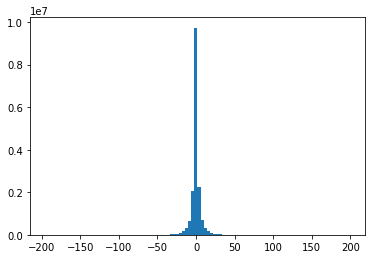

In [65]:
plt.hist(vx.value.flatten(),bins=100)
plt.show()

In [39]:
np.mean(vx),np.mean(cat['Vx'].compute())

(5.833822e-05, 5.8705173e-05)

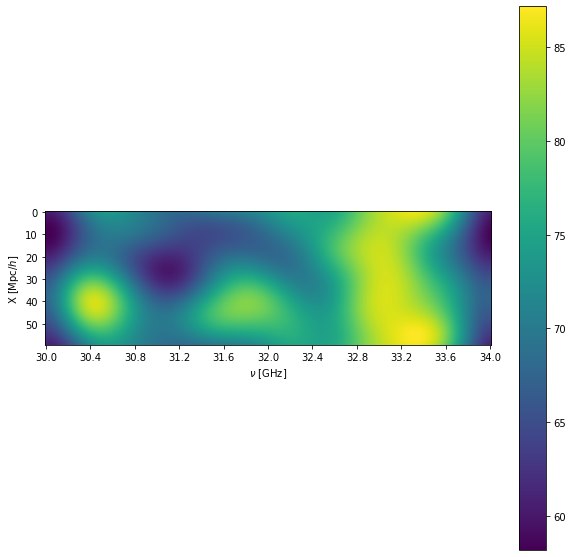

In [79]:
#Visualize the survey
plt.figure(figsize=(10, 10), facecolor='w')


N = 2

Nz, Nx, Ny = test.obs_map.shape


plt.imshow(test.obs_map.preview(axes=[N, 0])*u.uK)


plt.xticks(np.linspace(0, Nz-1, 11), np.round(np.linspace(30, 34, 11), 2))

#plt.yticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))
# plt.xticklabels()
plt.xlabel(r'$\nu$ [GHz]')

if N == 2:
    plt.ylabel(r'X [Mpc/$h$]')
elif N==1:
    plt.ylabel(r'Y [Mpc/$h$]')
plt.colorbar()

In [214]:
Vcell = Lboxes[0]/nmeshes[0]*Lboxes[1]/nmeshes[1]*Lboxes[2]/nmeshes[2]

In [217]:
np.sum(test.observed_halos['CO']['Lhalo'])

AttributeError: 'Survey' object has no attribute 'observed_halos'

AttributeError: 'Survey' object has no attribute 'methods'

In [1]:
signal = (cu.c**3*(1+self.halos_in_survey[line]['Ztrue'])**2/(8*np.pi*cu.k_B*self.line_nu0[line]**3*Hubble)*self.halos_in_survey[line]['Lhalo']/Vcell).to(self.unit)

NameError: name 'cu' is not defined

In [ ]:
zmid = (test.line_nu0['CO']/test.nuObs_mean).decompose().value-1
sigma_par = (cu.c*test.dnu*(1+zmid)/(test.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*test.nuObs_mean)).to(test.Mpch)




In [20]:
aa = test.obs_map - 10

In [12]:
import copy

In [17]:
aa += 20.

In [22]:
aa

RealField:array([[[10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       ...,

       [[10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10.

In [7]:
observed_catalog = dict(RA= np.array([]),DEC=np.array([]),Zobs=np.array([]),signal=np.array([]))

for line in test.lines.keys():
    if test.lines[line]:
        inds = np.where(np.logical_and(test.nuObs_line_halo[line] >= test.nuObs_min,
                                       test.nuObs_line_halo[line] <= test.nuObs_max))[0]
        observed_catalog['RA'] = np.append(observed_catalog['RA'],test.halo_catalog['RA'][inds])
        observed_catalog['DEC'] = np.append(observed_catalog['DEC'],test.halo_catalog['DEC'][inds])
        observed_catalog['Zobs'] = np.append(observed_catalog['Zobs'],test.line_nu0[test.target_line]/test.nuObs_line_halo[line][inds]-1)
        

In [6]:
import dask.array as da

In [7]:
ra,dec = da.broadcast_arrays(test.halos_in_survey['CO']['RA'], test.halos_in_survey['CO']['DEC'])
ra,dec  = da.deg2rad(ra),da.deg2rad(dec)
# cartesian coordinates
x = da.cos(dec) * da.cos(ra)
y = da.cos(dec) * da.sin(ra)
z = da.sin(dec)
pos = da.vstack([x,y,z]).T
ra,dec,redshift = da.broadcast_arrays(test.halos_in_survey['CO']['RA'], test.halos_in_survey['CO']['DEC'],test.halos_in_survey['CO']['Ztrue'])
#radial distances in Mpch/h
distances = test.cosmo.comoving_radial_distance(z)*u.Mpc
r = redshift.map_blocks(lambda z: (((test.cosmo.comoving_radial_distance(z)*u.Mpc).to(test.Mpch)).value), 
                        dtype=redshift.dtype)

/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/dask/array/core.py:1444: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [12]:
r

dask.array<lambda, shape=(591446,), dtype=float64, chunksize=(591446,), chunktype=numpy.ndarray>

In [8]:
nuObs_line_halo = {}
for line in test.lines.keys():
    if test.lines[line]:
        nuObs_line_halo[line] = test.line_nu0[line]/(1+test.halo_catalog['Z'])

In [227]:
import nbodykit
from nbodykit.transform import SkyToCartesian
from nbodykit.source.catalog import ArrayCatalog


In [282]:
#Just use default cosmo for now - but specify to MDPL2
cosmo = nbodykit.cosmology.Cosmology()

cartesian_halopos = SkyToCartesian(test.halos_in_survey['CO']['RA'], test.halos_in_survey['CO']['DEC'], test.halos_in_survey['CO']['Ztrue'], cosmo)





In [ ]:
def perp_filter(k, v):
    '''
    Filter for k_perp and k_par modes separately. 
    Applies to an nbodykit mesh object as a regular filter.
    
    "True input":
        Rperp - 'angular' smoothing in the flat sky approximation
        Rpar - 'radial' smoothing from number of channels.
    
    
    
    
    Usage:
        mesh.apply(perp_filter, mode='complex', kind='wavenumber')

    
    NOTES:
    k[0] *= modifies the next iteration in the loop.
    Coordinates are fixed except for the k[1] which are 
    the coordinate that sets what slab is being altered?
    
    '''
    rper = Rperp
    rpar = Rpar    
    newk = copy.deepcopy(k)
    
    
    #Smooth the k-modes anisotropically
    newk[0] *= rpar
    newk[1] *= rper
    newk[2] *= rper

    #Build smoothed values
    kk = sum(ki**2 for ki in newk)

    kk[kk==0]==1

    return np.exp(-0.5*kk)*v




lategrid = np.array(cartesian_halopos.compute())


#Translating grid such that bottom left corner of the box is [0,0,0] which is the nbodykit convention.
for n in range(3):
    if np.min(lategrid[:,n]) < 0:
        lategrid[:,n] += np.abs(np.min(lategrid[:,n]))
    else:
        lategrid[:,n] -= np.min(lategrid[:,n])
        
        
        
nbodycat = np.empty(len(cartesian_halopos), dtype=[('Position', ('f8', 3)), ('L', 'f8')])
nbodycat['Position'] = lategrid 


#Nbodykit weights are L_CO
nbodycat['L'] = test.halos_in_survey['CO']['Lhalo'].value#/((Lboxes[1]*Lboxes[2]/257**2)*Lboxes[0]/1000)

Lboxes = np.zeros(3)

#Middle redshift of the survey
zmid = 2.5


#pathfinder resolution is 6 arcmin
#6 arcmin is 6*np.pi/(60*180) radians
#use angular diameter distance at z=2.4 to figure out what Lgrid_perp should be.
#Still an approximate treatment.

theta_pathfinder = test.beam_width.to(u.rad).value


#This either sets the fundamental grid spacing for perpendicular coordinates or the smoothing scale
#from the beam.
Lgrid_perp = cosmo.comoving_transverse_distance(zmid)*theta_pathfinder

#Lgrid par comes from taking the frequency spacing, converting to a delta-z, and then converting to dchi.
#Just get Nmesh_par by taking the survey bandwidth and dividing by the channel width.
dnu = test.dnu.to(u.gigahertz)

Dnu = 2*u.gigahertz

dz = (dnu)*(1+zmid)**2 / test.line_nu0['CO']


#Lgrid_par = dchi = dz / H(z*). Take z* = zmid
#Should be in little h units now?
Lgrid_par = dz/(cosmo.efunc(zmid)*100* (u.kilometer/(u.second*u.megaparsec)))  * (cu.c).to(u.kilometer/u.second)


#Figure out cartesian size spanned by the lightcone
for n in range(3):
    Lboxes[n] = np.max(lategrid[:,n])-np.min(lategrid[:,n])
    

#Get Nmeshes to build grid - supersample by N=10 for aesthetic purposes.
nmeshes = np.array([10*(Dnu/dnu).value, 10*test.Nside[0], 10*test.Nside[1]], dtype=int)


#Build Nbodykit catalog object
cat = ArrayCatalog(nbodycat, Nmesh=nmeshes, BoxSize=Lboxes)

#Convert to a mesh, weighting by L_CO
mesh = cat.to_mesh(Nmesh=nmeshes, BoxSize=Lboxes, value='L',compensated=True, resampler='tsc',interlaced=True)


#Set globals for the anisotropic smoothing
#In the object-oriented framework these would be self.X quantities that are
#initialized when we start up the survey.
Rperp = Lgrid_perp
Rpar = Lgrid_par.to(u.gigaparsec).value



#Apply the filtering to create a separate, smoothed mesh
mesh_smooth = mesh.apply(perp_filter, mode='complex', kind='wavenumber')


#Paint the noiseless survey
LCO_survey = mesh.paint(mode='real')


#Paint the smoothed survey
LCO_survey_smooth = mesh_smooth.paint(mode='real')


In [323]:
np.sum(LCO_survey)

19228387000.0

In [321]:
np.sum(nbodycat['L'])/np.sum(LCO_survey)

0.8139743363061158

In [322]:
np.min(LCO_survey)

0.0

In [141]:
np.max(lategrid[:,2])

107.25251836175278

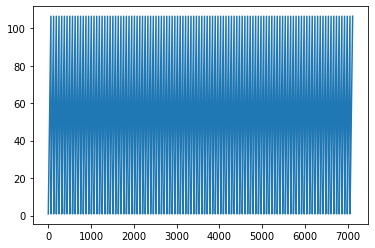

In [178]:
plt.plot(grid[:nmeshes[2]*nmeshes[1],2])

In [206]:
grid = np.zeros((nmeshes[0]*nmeshes[1]*nmeshes[2]+1,3))
xgrid = np.linspace(0.,Lboxes[0],nmeshes[0]+1)[:-1]+Lboxes[0]/nmeshes[0]/2
ygrid = np.linspace(0.,Lboxes[1],nmeshes[1]+1)[:-1]+Lboxes[1]/nmeshes[1]/2
zgrid = np.linspace(0.,Lboxes[2],nmeshes[2]+1)[:-1]+Lboxes[2]/nmeshes[2]/2
for i in range(nmeshes[0]):
    grid[nmeshes[1]*nmeshes[2]*i:nmeshes[1]*nmeshes[2]*(i+1),0] = xgrid[i]
for i in range(nmeshes[0]*nmeshes[1]):
    grid[nmeshes[2]*i:nmeshes[2]*(i+1),2] = zgrid
dummy = np.zeros(nmeshes[1]*nmeshes[2])
for i in range(nmeshes[1]):
    dummy[nmeshes[2]*i:nmeshes[2]*(i+1)] = ygrid[i]
for i in range(nmeshes[0]):
    grid[nmeshes[1]*nmeshes[2]*i:nmeshes[1]*nmeshes[2]*(i+1),1] = dummy

In [209]:


        
nbodycat = np.empty(len(grid), dtype=[('Position', ('f8', 3)), ('Weight', 'f8')])
nbodycat['Position'] = grid#np.concatenate((lategrid,grid))


#Nbodykit weights are L_CO
ww = np.random.normal(1000,10,grid.shape[0])
ww[-1] = 0.
nbodycat['Weight'] = ww#np.concatenate((test.L_line_halo['CO'][cutcat].value,np.ones((grid.shape[0],))*1e28))


In [202]:
np.sum(nbodycat['Weight'])

1423800243.9452226

In [203]:
np.sum(LCO_survey)

1423800.1

In [210]:
#Build Nbodykit catalog object
cat = ArrayCatalog(nbodycat, Nmesh=nmeshes, BoxSize=Lboxes)

#Convert to a mesh, weighting by L_CO
mesh = cat.to_mesh(Nmesh=nmeshes, BoxSize=Lboxes, weight='Weight')


#Set globals for the anisotropic smoothing
#In the object-oriented framework these would be self.X quantities that are
#initialized when we start up the survey.
Rperp = Lgrid_perp
Rpar = Lgrid_par.to(u.gigaparsec).value



#Apply the filtering to create a separate, smoothed mesh
mesh_smooth = mesh.apply(perp_filter, mode='complex', kind='wavenumber')


#Paint the noiseless survey
LCO_survey = mesh.paint(mode='real')


#Paint the smoothed survey
aa = mesh_smooth.paint(mode='real')


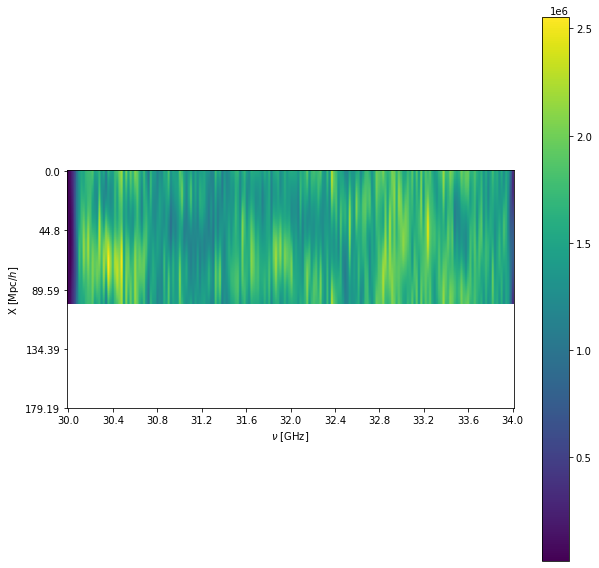

In [286]:
#Visualize the survey
plt.figure(figsize=(10, 10), facecolor='w')


N = 2

Nz, Nx, Ny = LCO_survey_smooth.shape


plt.imshow(LCO_survey_smooth.preview(axes=[N, 0])*u.uK)


plt.xticks(np.linspace(0, Nz-1, 11), np.round(np.linspace(30, 34, 11), 2))

plt.yticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))
# plt.xticklabels()
plt.xlabel(r'$\nu$ [GHz]')

if N == 2:
    plt.ylabel(r'X [Mpc/$h$]')
elif N==1:
    plt.ylabel(r'Y [Mpc/$h$]')
plt.colorbar()

In [135]:
np.max(grid[:,2])

107.25251836175278

In [107]:
test.L_line_halo['CO'][cutcat].value.shape

(1074446,)

In [74]:
grid = np.zeros((nmeshes[0]*nmeshes[1]*nmeshes[2],3))
xgrid = np.linspace(0.,Lboxes[0],nmeshes[0]+1)[:-1]+Lboxes[0]/nmeshes[0]
ygrid = np.linspace(0.,Lboxes[1],nmeshes[1]+1)[:-1]+Lboxes[1]/nmeshes[1]
zgrid = np.linspace(0.,Lboxes[2],nmeshes[2]+1)[:-1]+Lboxes[2]/nmeshes[2]
for i in range(nmeshes[0]):
    grid[nmeshes[1]*nmeshes[2]*i:nmeshes[1]*nmeshes[2]*(i+1),0] = xgrid[i]
for i in range(nmeshes[0]*nmeshes[1]):
    grid[nmeshes[2]*i:nmeshes[2]*(i+1),2] = zgrid
for i in range(nmeshes[1]):
    for j in range(nmeshes[0]):
    grid[i::nmeshes[2],1] = ygrid[i]

In [85]:
aa = np.arange(20)
aa[::2]

array([0, 2])

In [86]:
xg,yg,zg = np.meshgrid(xgrid,ygrid,zgrid)

In [90]:
xgr = xg.reshape((xg.size,1))
ygr = yg.reshape((xg.size,1))
zgr = zg.reshape((xg.size,1))

In [92]:
grid = np.array(np.hstack((xgr,ygr,zgr))

In [101]:
lategrid.shape

(1074446, 3)

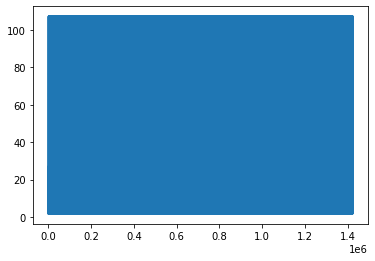

In [95]:
plt.plot(grid[:,2])

In [98]:
xgr[nmeshes[1]]

array([3.15084647])

In [19]:
aa = mesh_smooth.paint(mode='real',Nmesh=[200,60,60])

In [20]:
np.sum(LCO_survey_smooth)

793800.06

In [23]:
np.sum(aa)*63**2/60**2

793799.93109375

In [10]:
LCO_survey_smooth.shape

(1000, 878, 878)

In [16]:
test.Npix,878**2

(7396, 770884)

In [14]:
(86*86*10*10)**0.5

860.0

In [67]:
np.random.normal(0*u.uK,10*u.uK,3)

TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [44]:
aa = mesh_smooth.paint(mode='real',Nmesh = [1000,250,250])

In [60]:
aa = LCO_survey_smooth+np.random.normal(0,10,LCO_survey_smooth.shape)

In [64]:
aa *= 1.*u.uK

UnitTypeError: Cannot store quantity with dimension resulting from multiply function in a non-Quantity instance.

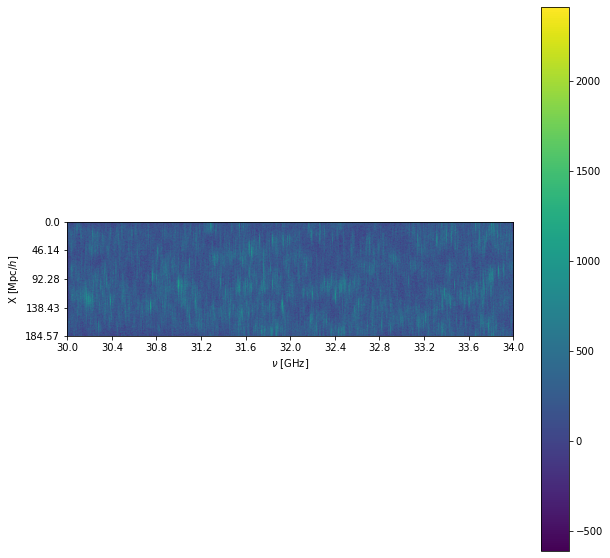

In [61]:
#Visualize the survey
plt.figure(figsize=(10, 10), facecolor='w')


N = 2

Nz, Nx, Ny = aa.shape


plt.imshow(aa.preview(axes=[N, 0])*u.uK)


plt.xticks(np.linspace(0, Nz-1, 11), np.round(np.linspace(30, 34, 11), 2))

plt.yticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))
# plt.xticklabels()
plt.xlabel(r'$\nu$ [GHz]')

if N == 2:
    plt.ylabel(r'X [Mpc/$h$]')
elif N==1:
    plt.ylabel(r'Y [Mpc/$h$]')
plt.colorbar()

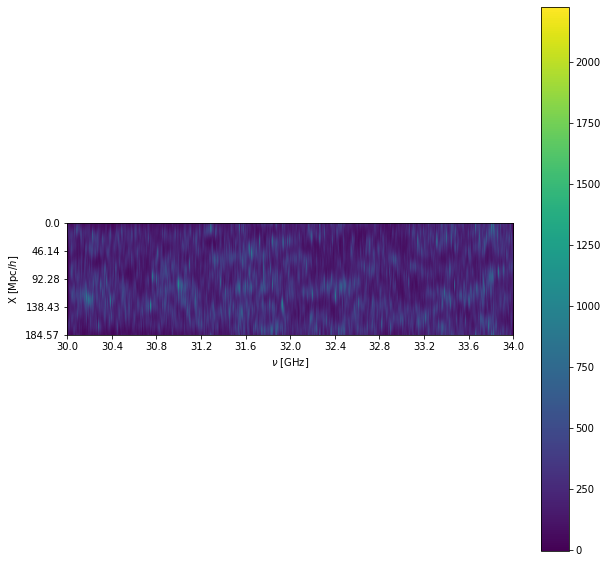

In [26]:
#Visualize the survey
plt.figure(figsize=(10, 10), facecolor='w')


N = 2

Nz, Nx, Ny = aa.shape


plt.imshow(aa.preview(axes=[N, 0])*u.uK)


plt.xticks(np.linspace(0, Nz-1, 11), np.round(np.linspace(30, 34, 11), 2))

plt.yticks(np.linspace(0, Nx-1, 5), np.round(np.linspace(np.min(lategrid[:,N]), np.max(lategrid[:,N]), 5), 2))
# plt.xticklabels()
plt.xlabel(r'$\nu$ [GHz]')

if N == 2:
    plt.ylabel(r'X [Mpc/$h$]')
elif N==1:
    plt.ylabel(r'Y [Mpc/$h$]')
plt.colorbar()

In [21]:
lategrid = np.array(cartesian_halopos.compute())


AttributeError: 'CAMBdata' object has no attribute 'comoving_distance'

In [22]:
import dask.array

In [23]:
cosmo = nbodykit.cosmology.Cosmology()


In [67]:
cosmo.comoving_transverse_distance(2)

3584.3949175194075

In [70]:
(test.cosmo.angular_diameter_distance(2)*3*u.Mpc).to(test.Mpch)*(cosmo.h/test.h)

<Quantity 3576.09867337 1.47059 Mpc>

In [30]:
cosmo.h

0.67556

In [43]:
np.max(test.halo_catalog['DEC'])

1.25

In [65]:
dnu = 40*u.MHz
dz = (dnu)*(1+2.6)**2 / test.line_nu0['CO']
dz/(cosmo.efunc(2.6)*100* (u.kilometer/(u.second*u.megaparsec)))  * (cu.c).to(u.kilometer/u.second)

<Quantity 3444.07571562 MHz Mpc / GHz>

In [66]:
(dz/(cosmo.efunc(2.6)*100* (u.kilometer/(u.second*u.megaparsec)))  * (cu.c).to(u.kilometer/u.second)).to(u.Mpc)

<Quantity 3.44407572 Mpc>

In [46]:
aa

array([False, False, False, ..., False, False, False])

In [47]:
bb

array([False, False, False, ..., False, False, False])

In [49]:
np.unique(aa*bb)

array([False,  True])

In [51]:
aa&bb

array([False, False, False, ..., False, False, False])

In [55]:
aa = dict(RA= np.array([]),DEC=np.array([]),Zobs=np.array([]),Ztrue=np.array([]))
bb = {}
bb['cc'] = copy.copy(aa)
bb['cc']['RA'] = 0

In [56]:
aa

{'RA': array([], dtype=float64),
 'DEC': array([], dtype=float64),
 'Zobs': array([], dtype=float64),
 'Ztrue': array([], dtype=float64)}

In [57]:
bb

{'cc': {'RA': 0,
  'DEC': array([], dtype=float64),
  'Zobs': array([], dtype=float64),
  'Ztrue': array([], dtype=float64)}}

In [63]:
test.halo_catalog[:100]

array([(-64.98419 , -1.2129339, 2.4436836,  7.38049159e-04,        3258593052, 1.1577000e+12, 1.96964905e+10, 2.73121651e-02),
       (-64.97961 , -1.2120714, 2.4434097,  1.33176148e-03,        3258593053, 1.3549000e+10, 3.18604925e+06, 2.66611832e-03),
       (-64.99277 , -1.2112316, 2.4439123,  2.61095981e-03,        3258593054, 2.5592000e+11, 1.49653773e+09, 3.00282311e+00),
       (-64.992615, -1.2116609, 2.4437253,  2.22886237e-03,  2000002948786092, 1.2043000e+10, 8.93910720e+07, 3.06150001e-02),
       (-64.991295, -1.2107117, 2.4438944,  2.47756531e-03,        3258593055, 3.9140999e+10, 1.52571008e+08, 2.36637101e-01),
       (-64.989525, -1.2130779, 2.4440007, -3.14487587e-03,        3258593056, 1.7010999e+11, 2.80763392e+08, 1.89469266e+00),
       (-64.99217 , -1.2022047, 2.4431176,  3.67092458e-03,        3258593057, 3.3119001e+10, 5.17843300e+06, 7.46063888e-03),
       (-64.97708 , -1.2090342, 2.4435248, -2.67669948e-05,        3258593058, 2.2581000e+10, 5.02273900e+06, 4

In [64]:
test.halo_catalog['RA'][:100]

array([-64.98419 , -64.97961 , -64.99277 , -64.992615, -64.991295,
       -64.989525, -64.99217 , -64.97708 , -64.99442 , -64.996155,
       -64.99835 , -64.98401 , -64.9887  , -64.987724, -64.99052 ,
       -64.98833 , -64.99117 , -64.99209 , -64.98531 , -64.96706 ,
       -64.971695, -64.97353 , -64.969315, -64.99784 , -64.99817 ,
       -64.965614, -64.95101 , -64.816864, -64.82391 , -64.81243 ,
       -64.824356, -64.809814, -64.819115, -64.801636, -64.80417 ,
       -64.80488 , -64.80018 , -64.79962 , -64.830315, -64.83146 ,
       -64.832756, -64.813835, -64.85368 , -64.82718 , -64.79373 ,
       -64.79383 , -64.78449 , -64.79274 , -64.78809 , -64.78821 ,
       -64.83588 , -64.850075, -64.85119 , -64.78181 , -64.78414 ,
       -64.8456  , -64.6634  , -64.66393 , -64.70864 , -64.63377 ,
       -64.6611  , -64.68858 , -64.68895 , -64.688065, -64.69346 ,
       -64.68778 , -64.91203 , -64.91615 , -64.87811 , -64.930145,
       -64.91572 , -64.91861 , -64.91082 , -64.91364 , -64.882